In [1]:
import pandas as pd
import numpy as np
import scipy 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import choices,sample

import os
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from datetime import timedelta
from tqdm import tqdm

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

os.chdir("../")
root_path = os.getcwd()

data_folder_path = os.path.join(root_path, 'data')
original_file_path = os.path.join(data_folder_path, 'original_data')
original_raw_file_path = os.path.join(original_file_path,'raw_data')
original_processed_file_path = os.path.join(original_file_path,'processed_data')

raw_file_folders = os.listdir(original_raw_file_path)

external_file_path = os.path.join(data_folder_path,'external_data')
external_raw_file_path = os.path.join(external_file_path,'raw_data')
external_processed_file_path = os.path.join(external_file_path,'processed_data')

c:\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
def register_add_time_property(register):
    register['STD_DD']=pd.to_datetime(register.STD_DD, format='%Y-%m-%d')
    
    register['year'] = register['STD_DD'].dt.year.values
    register['month'] = register['STD_DD'].dt.month.values
    register['weekofyear'] = register['STD_DD'].dt.weekofyear.values
    register['dayofweek'] = register['STD_DD'].dt.dayofweek.values

    register['weekday'] = np.where(register.dayofweek<5,'평일','주말')
    
    return register

In [8]:
def convert_code_to_name_register(register):
    df = register
    df['region_code'] = df.GU_CD.astype(str)+df.DONG_CD.astype(str)
    
    with open(os.path.join(original_processed_file_path, 'card_code_to_name_dict.pickle'), 'rb') as f:
        card_code_to_name_dict = pickle.load(f)
        
    cat_dict = {10 : '숙박',
                20 : '레저용품',
                21 : '레저업소',
                22 : '문화취미',
                30 : '가구',
                31 : '전기',
                32 : '주방용구',
                33 : '연료판매',
                34 : '광학제품',
                35 : '가전',
                40 : '유통업',
                42 : '의복',
                43 : '직물',
                44 : '신변잡화',
                50 : '서적문구',
                52 : '사무통신',
                60 : '자동차판매',
                62 : '자동차 정비',
                70 : '의료기관',
                71 : '보건위생',
                80 : '요식업소',
                81 : '음료식품',
                92 : '수리서비스'}
    
    df['GU_NM'] = df.region_code.map(card_code_to_name_dict.get('구명'))
    df['HDONG_NM'] = df.region_code.map(card_code_to_name_dict.get('행정동명'))
    df['MCT_CAT_NM'] = df.MCT_CAT_CD.map(cat_dict)
    
    return df

In [4]:
sk_files = [file for file in os.listdir(original_processed_file_path) if file.startswith('SK_melted')]
card_files = [file for file in os.listdir(original_processed_file_path) if file.startswith('카드')]

In [5]:
df_list_card = []

for file_name in card_files:
    file_path = os.path.join(original_processed_file_path, file_name)
    df = pd.read_csv(file_path)
    df_list_card.append(df)

In [6]:
df_list_sk = []

for file_name in sk_files:
    file_path = os.path.join(original_processed_file_path, file_name)
    df = pd.read_csv(file_path)
    df_list_sk.append(df)

In [16]:
register = df_list_card[0]

register = convert_code_to_name_register(register)
register = register_add_time_property(register)

register.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,region_code,GU_NM,HDONG_NM,MCT_CAT_NM,year,month,weekofyear,dayofweek,weekday
0,2019-02-01,110,517,10,F,25,11,595,110517,대구 중구,동인동,숙박,2019,2,5,4,평일
1,2019-02-01,110,517,10,F,50,5,243,110517,대구 중구,동인동,숙박,2019,2,5,4,평일
2,2019-02-01,110,517,10,F,55,5,27,110517,대구 중구,동인동,숙박,2019,2,5,4,평일
3,2019-02-01,110,517,10,M,20,11,243,110517,대구 중구,동인동,숙박,2019,2,5,4,평일
4,2019-02-01,110,517,10,M,25,11,433,110517,대구 중구,동인동,숙박,2019,2,5,4,평일


In [10]:
fp_age= df_list_sk[0]
fp_time = df_list_sk[1]

### 행정동별 Risk Index

* RISK INDEX
 
    * 코로나기간 (3월최저점 ~ +7일) - (2월최고점 ~ +7일)  
    => 기간 1주일로 잡은이유 
        : 카드소비 및 유통(GS편의점)소비에서 모두 일주일마다 소비의 패턴이 유사함을 볼 수 있었음. 따라서 1주일을 기간의 unit으로 설정하였고 기간이 길어질수록, 코로나 상황이 가장심했던 기간이후 소비가 회복되는 시점을 포함하는 경우가 많아져 1주일을 기준으로 잡게 됨
    * 비교구간 (2019년 2월,3월)
    => 기간 1달 : 평상시 상황을 최대한 고려하기 위해 기간을 좀 더 넓게 잡음
    
        * 유동인구
        * 카드소비액
            * 불규칙하게 소비액이 급등하는 날이 있었고, 이에 대한 타당한 이유를 찾지 못해 각 기간동안 하위5%, 상위5% 소비액을 제외한후 평균소비액을 구함. 평균소비액을 사용한 이유는 2월과 3월의 일수가 달라 합으로 계산했을시 왜곡된 결과가 나올수 있다고 생각했기 때문         
        * 카드소비횟수
            * 카드소비액과 동일한 방식

In [24]:
def get_minValue_date(df):
    df_mar_2020 = df.query('year==2020 & month==3')
    min2020 = (df_mar_2020.groupby(['STD_DD'])['USE_CNT'].sum()).idxmin()
    doy_class = np.where(min2020.dayofweek < 5,1,0) # dayofweek class==1 : 평일, dayofweek class==0 : 주말
    return min2020, doy_class

In [25]:
for col in register.MCT_CAT_NM.unique():
    tmp = register.loc[register.MCT_CAT_NM==col]
    print(f'{col} : {get_minValue_date(tmp)}')

숙박 : (Timestamp('2020-03-23 00:00:00'), array(1))
레저용품 : (Timestamp('2020-03-10 00:00:00'), array(1))
레저업소 : (Timestamp('2020-03-30 00:00:00'), array(1))
전기 : (Timestamp('2020-03-15 00:00:00'), array(0))
주방용구 : (Timestamp('2020-03-01 00:00:00'), array(0))
연료판매 : (Timestamp('2020-03-01 00:00:00'), array(0))
광학제품 : (Timestamp('2020-03-01 00:00:00'), array(0))
유통업 : (Timestamp('2020-03-08 00:00:00'), array(0))
사무통신 : (Timestamp('2020-03-01 00:00:00'), array(0))
자동차 정비 : (Timestamp('2020-03-01 00:00:00'), array(0))
의료기관 : (Timestamp('2020-03-08 00:00:00'), array(0))
보건위생 : (Timestamp('2020-03-10 00:00:00'), array(1))
요식업소 : (Timestamp('2020-03-01 00:00:00'), array(0))
음료식품 : (Timestamp('2020-03-15 00:00:00'), array(0))
수리서비스 : (Timestamp('2020-03-08 00:00:00'), array(0))
문화취미 : (Timestamp('2020-03-10 00:00:00'), array(1))
가구 : (Timestamp('2020-03-01 00:00:00'), array(0))
가전 : (Timestamp('2020-03-08 00:00:00'), array(0))
의복 : (Timestamp('2020-03-01 00:00:00'), array(0))
신변잡화 : (Timestamp('2

In [26]:
def get_minNmax_fp_date(df):
    
    #설연휴 유동인구의 경우 특별한 케이스이므로 제외    
    df_feb_2019 = df.query('year==2019 & month==2 & STD_YMD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']')
    df_mar_2019 = df.query('year==2019 & month==3')
    
    df_feb_2020 = df.query('year==2020 & month==2')
    df_mar_2020 = df.query('year==2020 & month==3')
    
    mx2019 = (df_feb_2019.groupby(['STD_YMD'])['flow_counts'].sum()).idxmax()
    mn2019 = (df_mar_2019.groupby(['STD_YMD'])['flow_counts'].sum()).idxmin()
    
    mx2020 = (df_feb_2020.groupby(['STD_YMD'])['flow_counts'].sum()).idxmax()
    mn2020 = (df_mar_2020.groupby(['STD_YMD'])['flow_counts'].sum()).idxmin()
    
    return mn2019,mx2019,mn2020,mx2020

In [27]:
def risk_index_fp(df, covid_weight=.5):
    hdong = list(df.HDONG_NM.unique())
    risk_by_dong = {}
    
    for dong in tqdm(hdong):
        tmp_df = df.loc[df.HDONG_NM==dong]
        min2019,max2019,min2020,max2020 = get_minNmax_fp_date(tmp_df)
        
        tmp_df = tmp_df.groupby('STD_YMD')['flow_counts'].sum().reset_index()
        
        # min_date_index_2019 = tmp_df[tmp_df.STD_YMD == min2019].index.values[0]
        # max_date_index_2019 = tmp_df[tmp_df.STD_YMD == max2019].index.values[0]
        
        min_date_index_2020 = tmp_df[tmp_df.STD_YMD == min2020].index.values[0]
        max_date_index_2020 = tmp_df[tmp_df.STD_YMD == max2020].index.values[0]
        
        # fp_feb_2019 = tmp_df.iloc[min_date_index_2019:min_date_index_2019+7,1].sum()
        # fp_mar_2019 = tmp_df.iloc[max_date_index_2019:max_date_index_2019+7,1].sum()
        
        fp_feb_2019 = tmp_df.iloc[:28,1].mean()
        fp_mar_2019 = tmp_df.iloc[28:28+31,1].mean()
        
        fp_feb_2020 = tmp_df.iloc[max_date_index_2020:max_date_index_2020+7,1].sum()
        fp_mar_2020 = tmp_df.iloc[min_date_index_2020:min_date_index_2020+7,1].sum()
        
        r1 = (fp_mar_2019 - fp_feb_2019)/fp_feb_2019
        r2 = (fp_mar_2020 - fp_feb_2020)/fp_feb_2020
        
        risk = (r2*covid_weight)-(r1*(1-covid_weight))
        
        risk_by_dong[dong] = risk
        
    return risk_by_dong

In [28]:
def plot_fp_risk(df, dong):
    tmp_df = df.loc[df.HDONG_NM==dong].reset_index(drop=True)
    
    tmp_df['STD_YMD'] = tmp_df.STD_YMD.astype(str)
    
    mean_feb_2019 = tmp_df.query('year==2019 & month==2').groupby('STD_YMD')['flow_counts'].sum().mean()
    mean_mar_2019 = tmp_df.query('year==2019 & month==3').groupby('STD_YMD')['flow_counts'].sum().mean()
    
    max_feb_2020 = np.max(tmp_df.query('year==2020 & month==2').groupby('STD_YMD')['flow_counts'].sum())

    fig, ax = plt.subplots(figsize=(16,9))
    ax = sns.lineplot(
        data = tmp_df.groupby('STD_YMD')['flow_counts'].sum().reset_index(),
        x = 'STD_YMD',
        y = 'flow_counts',
        color = 'k',
        linewidth=0.8
    )
    
    low, high = ax.get_ybound()
    
    # ax.vlines(x=120.5, ymin=low*0.9, ymax=high*1.1, color='blue', linewidth=0.8)
    
    ax.hlines(y=mean_feb_2019, xmin=-0.5, xmax=28.5, color = 'blue')
    ax.hlines(y=mean_mar_2019, xmin=28.5, xmax=59.5, color = 'blue')
    
    if mean_mar_2019 - mean_feb_2019 > 0:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 증가', (24, mean_mar_2019*1.05), color='red', fontsize=16)
    else:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 감소', (24, mean_feb_2019*0.8), color='blue', fontsize=16)
    
    ax.annotate(s='2019년', xy=(5,high*0.95), fontsize=20)
    ax.annotate(s='2020년', xy=(125,high*0.95), fontsize=20)
    ax.annotate(s='', xy=(28.5,mean_feb_2019), xytext=(28.5,mean_mar_2019), arrowprops=dict(arrowstyle='<->', color='blue'))
    ax.axvspan(xmin=120, xmax=241, color='skyblue', alpha=0.1)

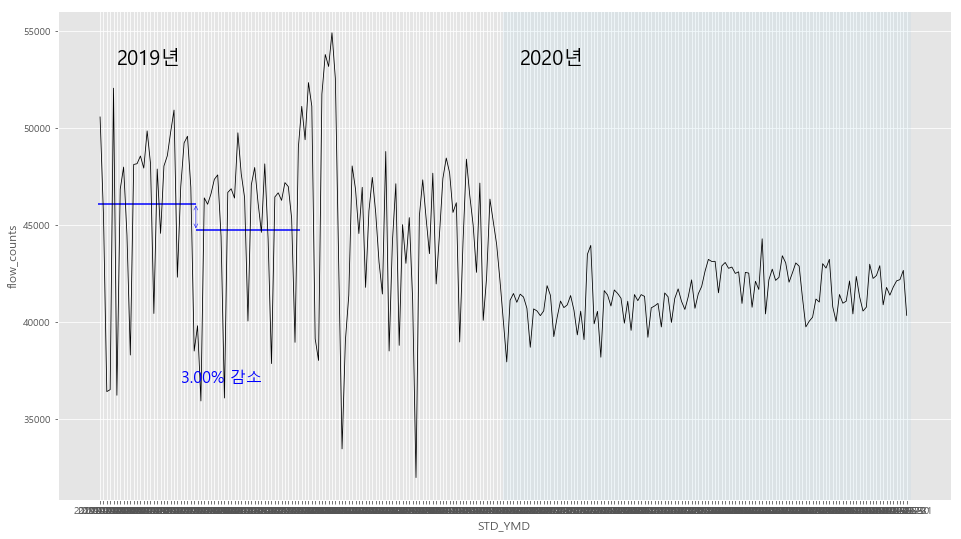

In [29]:
plot_fp_risk(fp_time,'월계2동')

In [35]:
def get_minNmax_cardAMT_date(df):
    
    # 설연휴 유동인구의 경우 특별한 케이스이므로 제외    
    # df_feb_2019 = df.query('year==2019 & month==2 & STD_DD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']')
    # df_mar_2019 = df.query('year==2019 & month==3')
    
    df_feb_2020 = df.query('year==2020 & month==2')
    df_mar_2020 = df.query('year==2020 & month==3')
    
    # mx2019 = np.argmax(df_feb_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    # mn2019 = np.argmin(df_mar_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    
    mx2020 = (df_feb_2020.groupby(['STD_DD'])['USE_AMT'].sum()).idxmax()
    mn2020 = (df_mar_2020.groupby(['STD_DD'])['USE_AMT'].sum()).idxmin()
    
    return mn2020,mx2020

In [36]:
# outlier제거하는 방향으로 해봐야할듯

def risk_index_cardAMT(df):
    hdong = list(df.HDONG_NM.unique())
    risk_by_dong = {}
    
    for dong in tqdm(hdong):
        tmp_df = df.loc[df.HDONG_NM==dong]
        min2020,max2020 = get_minNmax_cardAMT_date(tmp_df)
        
        tmp_df = tmp_df.groupby(['STD_DD','year','month'])['USE_AMT'].sum().reset_index()
        
        min_date_index_2020 = tmp_df[tmp_df.STD_DD == min2020].index.values[0]
        max_date_index_2020 = tmp_df[tmp_df.STD_DD == max2020].index.values[0]
        
        # 2월과 3월의 날짜가 차이가 나기때문에 평균소비액으로 계산
        # 가끔 불규칙한 주기로 매출액이 유독 높아지는 날이 있음. 이에 대한 근거가 생기기 전까지는 이상치로 판단하여
        # 제거하는 방향으로 진행.
        
        # 하위 5%와 상위5% 소비금액 제거후 평균계산
        # 5%기준으로 한 이유 : 월별로 값을 보기때문에 데이터의 크기가 31을 넘지 않음. 가장 큰 날 하루를 뺀다고 했을때 이미 3%가 넘으므로 5%를 기준으로 하게 됨
        feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.95]).astype(int).tolist()
        mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.95]).astype(int).tolist()
        
        # mean_cardAMT_feb_2019 = tmp_df.iloc[:28,1].mean() # 19.02.01 ~ 19.02.28까지 매출의 평균
        # mean_cardAMT_mar_2019 = tmp_df.iloc[28:28+31,1].mean() # 19.03.01 ~ 19.03.31까지 매출의 평균
        
        mean_cardAMT_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum() \
                             if val in range(*feb_2019_filter)])
        mean_cardAMT_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum() \
                                 if val in range(*mar_2019_filter)]) 
        
        #
        cardAMT_feb_2020 = tmp_df.iloc[min_date_index_2020:min_date_index_2020+7,-1].sum()
        cardAMT_mar_2020 = tmp_df.iloc[max_date_index_2020:max_date_index_2020+7,-1].sum()
        
        r1 = (mean_cardAMT_mar_2019 - mean_cardAMT_feb_2019)/mean_cardAMT_feb_2019
        r2 = (cardAMT_mar_2020 - cardAMT_feb_2020)/cardAMT_feb_2020
        
        risk = np.sqrt((r1+1)*(r2+1))-1
        
        risk_by_dong[dong] = risk
        
    return risk_by_dong

In [37]:
def plot_cardAMT_risk(df, dong):
    tmp_df = df.loc[df.HDONG_NM==dong].reset_index(drop=True)
    
    tmp_df['STD_DD'] = tmp_df.STD_DD.astype(str)
    
    feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.9]).astype(int).tolist()
    mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum().quantile([.05,.9]).astype(int).tolist()
    
    # mean_feb_2019 = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum().mean()
    # mean_mar_2019 = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum().mean()
    
    mean_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_AMT'].sum() \
                         if val in range(*feb_2019_filter)])
    mean_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_AMT'].sum() \
                            if val in range(*mar_2019_filter)])
    
    max_feb_2020 = np.max(tmp_df.query('year==2020 & month==2').groupby('STD_DD')['USE_AMT'].sum())

    fig, ax = plt.subplots(figsize=(16,9))
    ax = sns.lineplot(
        data = tmp_df.groupby('STD_DD')['USE_AMT'].sum().reset_index(),
        x = 'STD_DD',
        y = 'USE_AMT',
        color = 'k',
        linewidth=0.8
    )
    
    low, high = ax.get_ybound()
    
    # ax.vlines(x=120.5, ymin=low*0.9, ymax=high*1.1, color='blue', linewidth=0.8)
    
    ax.hlines(y=mean_feb_2019, xmin=-0.5, xmax=28.5, color = 'blue')
    ax.hlines(y=mean_mar_2019, xmin=28.5, xmax=59.5, color = 'blue')
    
    if mean_mar_2019 - mean_feb_2019 > 0:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 증가', (24, mean_mar_2019*1.05), color='red', fontsize=16)
    else:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 감소', (24, mean_feb_2019*0.8), color='blue', fontsize=16)
    
    ax.annotate(s='2019년', xy=(5,high*0.95), fontsize=20)
    ax.annotate(s='2020년', xy=(125,high*0.95), fontsize=20)
    ax.annotate(s='', xy=(28.5,mean_feb_2019), xytext=(28.5,mean_mar_2019), arrowprops=dict(arrowstyle='<->', color='blue'))
    ax.axvspan(xmin=120, xmax=241, color='skyblue', alpha=0.1)

In [38]:
risk_index_card = risk_index_cardAMT(register)

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:10<00:00,  6.45it/s]


In [41]:
def get_minNmax_cardCNT_date(df):
    
    # 설연휴 유동인구의 경우 특별한 케이스이므로 제외    
    # df_feb_2019 = df.query('year==2019 & month==2 & STD_DD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']')
    # df_mar_2019 = df.query('year==2019 & month==3')
    
    df_feb_2020 = df.query('year==2020 & month==2')
    df_mar_2020 = df.query('year==2020 & month==3')
    
    # mx2019 = np.argmax(df_feb_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    # mn2019 = np.argmin(df_mar_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    
    mx2020 = (df_feb_2020.groupby(['STD_DD'])['USE_CNT'].sum()).idxmax()
    mn2020 = (df_mar_2020.groupby(['STD_DD'])['USE_CNT'].sum()).idxmin()
    
    return mn2020,mx2020

In [42]:
# outlier제거하는 방향으로 해봐야할듯

def risk_index_cardCNT(df,  covid_weight=.6):
    hdong = list(df.HDONG_NM.unique())
    risk_by_dong = {}
    
    for dong in tqdm(hdong):
        tmp_df = df.loc[df.HDONG_NM==dong]
        min2020,max2020 = get_minNmax_cardCNT_date(tmp_df)
        
        tmp_df = tmp_df.groupby(['STD_DD','year','month'])['USE_CNT'].sum().reset_index()
        
        min_date_index_2020 = tmp_df[tmp_df.STD_DD == min2020].index.values[0]
        max_date_index_2020 = tmp_df[tmp_df.STD_DD == max2020].index.values[0]
        
        # 2월과 3월의 날짜가 차이가 나기때문에 평균소비액으로 계산
        # 가끔 불규칙한 주기로 매출액이 유독 높아지는 날이 있음. 이에 대한 근거가 생기기 전까지는 이상치로 판단하여
        # 제거하는 방향으로 진행.
        
        # 하위 5%와 상위5% 소비금액 제거후 평균계산
        # 5%기준으로 한 이유 : 월별로 값을 보기때문에 데이터의 크기가 31을 넘지 않음. 가장 큰 날 하루를 뺀다고 했을때 이미 3%가 넘으므로 5%를 기준으로 하게 됨
        feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
        mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
        
        # mean_cardCNT_feb_2019 = tmp_df.iloc[:28,1].mean() # 19.02.01 ~ 19.02.28까지 매출의 평균
        # mean_cardCNT_mar_2019 = tmp_df.iloc[28:28+31,1].mean() # 19.03.01 ~ 19.03.31까지 매출의 평균
        
        mean_cardCNT_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum() \
                             if val in range(*feb_2019_filter)])
        mean_cardCNT_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum() \
                                 if val in range(*mar_2019_filter)]) 
        
        # cardCNT_feb_2020 = tmp_df.iloc[min_date_index_2020:min_date_index_2020+7,-1].sum()
        
        if (max2020 - pd.to_datetime('20200201', format='%Y%m%d')).days >= 6 :
            cardCNT_mar_2020 = tmp_df.iloc[min_date_index_2020-6:min_date_index_2020+1,-1].sum()
        else:
            time_to_first = (max2020 - pd.to_datetime('20200201', format='%Y%m%d')).days
            cardCNT_mar_2020 = tmp_df.iloc[min_date_index_2020-time_to_first:min_date_index_2020+(7-time_to_first),-1].sum()
        cardCNT_feb_2020 = tmp_df.iloc[max_date_index_2020:max_date_index_2020+7,-1].sum()
        
        r1 = (mean_cardCNT_mar_2019 - mean_cardCNT_feb_2019)/mean_cardCNT_feb_2019
        r2 = (cardCNT_mar_2020 - cardCNT_feb_2020)/cardCNT_feb_2020
        
        # risk = (np.abs(r2-r1)/(r2-r1))*(np.sqrt((r1+1)*(r2+1))-1)
        risk = ((r2*covid_weight)-(r1*(1-covid_weight)))
        
        risk_by_dong[dong] = risk
        
    return risk_by_dong

In [43]:
def plot_cardCNT_risk(df, dong,):
    tmp_df = df.loc[df.HDONG_NM==dong].reset_index(drop=True)
    
    tmp_df['STD_DD'] = tmp_df.STD_DD.astype(str)
    
    feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
    mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
    
    # mean_feb_2019 = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().mean()
    # mean_mar_2019 = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().mean()
    
    mean_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum() \
                         if val in range(*feb_2019_filter)])
    mean_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum() \
                            if val in range(*mar_2019_filter)])
    
    max_feb_2020 = np.max(tmp_df.query('year==2020 & month==2').groupby('STD_DD')['USE_CNT'].sum())

    fig, ax = plt.subplots(figsize=(16,9))
    ax = sns.lineplot(
        data = tmp_df.groupby('STD_DD')['USE_CNT'].sum().reset_index(),
        x = 'STD_DD',
        y = 'USE_CNT',
        color = 'k',
        linewidth=0.8
    )
    
    low, high = ax.get_ybound()
    
    # ax.vlines(x=120.5, ymin=low*0.9, ymax=high*1.1, color='blue', linewidth=0.8)
    ax.vlines(x=149, ymin=low, ymax=high)
    ax.hlines(y=mean_feb_2019, xmin=-0.5, xmax=28.5, color = 'blue')
    ax.hlines(y=mean_mar_2019, xmin=28.5, xmax=59.5, color = 'blue')
    
    if mean_mar_2019 - mean_feb_2019 > 0:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 증가', (24, mean_mar_2019*1.05), color='red', fontsize=16)
    else:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 감소', (24, mean_feb_2019*0.8), color='blue', fontsize=16)
    
    ax.annotate(s='2019년', xy=(5,high*0.95), fontsize=20)
    ax.annotate(s='2020년', xy=(125,high*0.95), fontsize=20)
    ax.annotate(s='', xy=(28.5,mean_feb_2019), xytext=(28.5,mean_mar_2019), arrowprops=dict(arrowstyle='<->', color='blue'))
    ax.axvspan(xmin=120, xmax=241, color='skyblue', alpha=0.1)

In [44]:
card_risk = risk_index_cardCNT(register)

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:10<00:00,  6.45it/s]


### 업종별 Risk Index

업종별 일별 USE_CNT에 대한 RISK INDEX

In [45]:
def get_minNmax_cardCNT_date(df):
    
    # 설연휴 유동인구의 경우 특별한 케이스이므로 제외    
    # df_feb_2019 = df.query('year==2019 & month==2 & STD_DD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']')
    # df_mar_2019 = df.query('year==2019 & month==3')
    
    df_feb_2020 = df.query('year==2020 & month==2')
    df_mar_2020 = df.query('year==2020 & month==3')
    
    # mx2019 = np.argmax(df_feb_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    # mn2019 = np.argmin(df_mar_2019.groupby(['STD_YMD'])['flow_counts'].sum())
    
    mx2020 = (df_feb_2020.groupby(['STD_DD'])['USE_CNT'].sum()).idxmax()
    mn2020 = (df_mar_2020.groupby(['STD_DD'])['USE_CNT'].sum()).idxmin()
    
    return mn2020,mx2020

In [46]:
# outlier제거하는 방향으로 해봐야할듯

def cat_risk_index_cardCNT(df,  covid_weight=.6):
    categories = list(df.MCT_CAT_NM.unique())
    risk_by_dong = {}
    
    for cat in tqdm(categories):
        tmp_df = df.loc[df.MCT_CAT_NM==cat]
        min2020,max2020 = get_minNmax_cardCNT_date(tmp_df)
        
        tmp_df = tmp_df.groupby(['STD_DD','year','month'])['USE_CNT'].sum().reset_index()
        
        min_date_index_2020 = tmp_df[tmp_df.STD_DD == min2020].index.values[0]
        max_date_index_2020 = tmp_df[tmp_df.STD_DD == max2020].index.values[0]
        
        # 2월과 3월의 날짜가 차이가 나기때문에 평균소비액으로 계산
        # 가끔 불규칙한 주기로 매출액이 유독 높아지는 날이 있음. 이에 대한 근거가 생기기 전까지는 이상치로 판단하여
        # 제거하는 방향으로 진행.
        
        # 하위 5%와 상위5% 소비금액 제거후 평균계산
        # 5%기준으로 한 이유 : 월별로 값을 보기때문에 데이터의 크기가 31을 넘지 않음. 가장 큰 날 하루를 뺀다고 했을때 이미 3%가 넘으므로 5%를 기준으로 하게 됨
        feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
        mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
        
        # mean_cardCNT_feb_2019 = tmp_df.iloc[:28,1].mean() # 19.02.01 ~ 19.02.28까지 매출의 평균
        # mean_cardCNT_mar_2019 = tmp_df.iloc[28:28+31,1].mean() # 19.03.01 ~ 19.03.31까지 매출의 평균
        
        mean_cardCNT_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum() \
                             if val in range(*feb_2019_filter)])
        mean_cardCNT_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum() \
                                 if val in range(*mar_2019_filter)]) 
        
        # cardCNT_feb_2020 = tmp_df.iloc[min_date_index_2020:min_date_index_2020+7,-1].sum()
        
        if (max2020 - pd.to_datetime('20200201', format='%Y%m%d')).days >= 6 :
            cardCNT_mar_2020 = tmp_df.iloc[min_date_index_2020-6:min_date_index_2020+1,-1].sum()
        else:
            time_to_first = (max2020 - pd.to_datetime('20200201', format='%Y%m%d')).days
            cardCNT_mar_2020 = tmp_df.iloc[min_date_index_2020-time_to_first:min_date_index_2020+(7-time_to_first),-1].sum()
        cardCNT_feb_2020 = tmp_df.iloc[max_date_index_2020:max_date_index_2020+7,-1].sum()
        
        r1 = (mean_cardCNT_mar_2019 - mean_cardCNT_feb_2019)/mean_cardCNT_feb_2019
        r2 = (cardCNT_mar_2020 - cardCNT_feb_2020)/cardCNT_feb_2020
        
        # risk = (np.abs(r2-r1)/(r2-r1))*(np.sqrt((r1+1)*(r2+1))-1)
        risk = ((r2*covid_weight)-(r1*(1-covid_weight)))
        
        risk_by_cat[cat] = risk
        
    return risk_by_cat

In [47]:
def plot_cat_cardCNT_risk(df, cat, risk_index_dict=None):
    if risk_index_dict != None:
        risk = risk_index_dict.get(cat)
    tmp_df = df.loc[df.MCT_CAT_NM==cat].reset_index(drop=True)
    
    tmp_df['STD_DD'] = tmp_df.STD_DD.astype(str)
    # labels = list(tmp_df.STD_DD.unique())
    
    feb_2019_filter = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
    mar_2019_filter = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().quantile([.05,.95]).astype(int).tolist()
    
    # mean_feb_2019 = tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum().mean()
    # mean_mar_2019 = tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum().mean()
    
    mean_feb_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==2').groupby('STD_DD')['USE_CNT'].sum() \
                         if val in range(*feb_2019_filter)])
    mean_mar_2019 = np.mean([val for val in tmp_df.query('year==2019 & month==3').groupby('STD_DD')['USE_CNT'].sum() \
                            if val in range(*mar_2019_filter)])
    
    max_feb_2020 = np.max(tmp_df.query('year==2020 & month==2').groupby('STD_DD')['USE_CNT'].sum())

    fig, ax = plt.subplots(figsize=(16,9))
    ax = sns.lineplot(
        data = tmp_df.groupby('STD_DD')['USE_CNT'].sum().reset_index(),
        x = 'STD_DD',
        y = 'USE_CNT',
        color = 'k',
        linewidth=0.8
    )
    
    low, high = ax.get_ybound()
    
    # ax.vlines(x=120.5, ymin=low*0.9, ymax=high*1.1, color='blue', linewidth=0.8)
    # ax.vlines(x=149, ymin=low, ymax=high) # 3월1일 기준선
    
    ax.hlines(y=mean_feb_2019, xmin=-0.5, xmax=28.5, color = 'blue')
    ax.hlines(y=mean_mar_2019, xmin=28.5, xmax=59.5, color = 'blue')
    
    if mean_mar_2019 - mean_feb_2019 > 0:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 증가', (24, mean_mar_2019*1.05), color='red', fontsize=16)
    else:
        ax.annotate(f'{np.abs((mean_mar_2019 - mean_feb_2019)/mean_feb_2019):.2%} 감소', (24, mean_feb_2019*0.8), color='blue', fontsize=16)
    
    ax.annotate(s='2019년', xy=(5,high*0.95), fontsize=20)
    ax.annotate(s='2020년', xy=(125,high*0.95), fontsize=20)
    ax.annotate(s='', xy=(28.5,mean_feb_2019), xytext=(28.5,mean_mar_2019), arrowprops=dict(arrowstyle='<->', color='blue'))
     
    ax.axvspan(xmin=120, xmax=241, color='skyblue', alpha=0.1)
    if risk_index_dict != None:
        ax.annotate(s=f'Risk Index : {risk:.2f}', xy =(125,high*0.85), fontsize=16)
    
    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False
    )
    ax.set_title(f'{cat}', fontsize=18)
    
    plt.show()

### Risk Indices 

In [48]:
def get_minValue_date(df, covid_start='2020-02-21', covid_max='2020-03-15'):
    
    covid_period = pd.date_range(start=covid_start, end=covid_max)
    normal_period = covid_period - timedelta(365)
    
    dayofweek_startdate = covid_period[0].dayofweek
    weekofyear_startdate = covid_period[0].weekofyear
    
    df_in_covid = df.loc[df.STD_DD.isin(covid_period)]
    df_in_normal = df.loc[df.STD_DD.isin(normal_period)]
    
    min2020 = df_in_covid.groupby(['STD_DD'])['USE_CNT'].sum().idxmin()
    min2019 = df_in_normal.groupby(['STD_DD'])['USE_CNT'].sum().idxmin()
    
    return dayofweek_startdate, weekofyear_startdate, min2020, min2019

In [50]:
def risk_index(df,mode='CARD', group_col='MCT_CAT_NM', val='USE_CNT', covid_weight=.5, return_aux=False):
    cat_list = df[group_col].unique().tolist()
    risk_index_dict = {}
    aux_dict = {}
    
    for cat in tqdm(cat_list):
        tmp_df = df.loc[df[group_col]==cat]
        
        # 설연휴 데이터 제외
                
        tmp_2019 = tmp_df.query('year==2019 & STD_DD not in[\'2019-02-01\',\'2019-02-02\',\'2019-02-03\',\'2019-02-04\',\'2019-02-05\',\'2019-02-06\']').reset_index(drop=True)
        tmp_2020 = tmp_df.query('year==2020').reset_index(drop=True)
        
        dayofweek_startdate, weekofyear_startdate, min_2020, min_2019 = get_minValue_date(tmp_df)
        
        tmp_2019 = tmp_2019.groupby(['STD_DD','year','month','weekofyear','dayofweek'])[val].sum().reset_index()
        tmp_2020 = tmp_2020.groupby(['STD_DD','year','month','weekofyear','dayofweek'])[val].sum().reset_index()
        
        # starting_week : 2019년(설연휴 이후), 2020년의 첫번째 날짜의 주차 중 더 이후의 주차
        # starting_day : 2019년(설연휴 이후), 2020년의 각 starting_week에서 처음 등장하는 요일 중 더 이후의 요일 (월->일 순)
        
        starting_week = np.max([tmp_2019.weekofyear.min(), tmp_2020.weekofyear.min()])
        starting_day = np.max([tmp_2019.loc[tmp_2019.weekofyear==starting_week].dayofweek.min(), tmp_2020.loc[tmp_2020.weekofyear==starting_week].dayofweek.min()])
        
        # starting_point : 
        # split_point : 코로나 시작일
        starting_point_2019 = tmp_2019.loc[(tmp_2019.weekofyear==starting_week) & (tmp_2019.dayofweek==starting_day)].index[0]
        starting_point_2020 = tmp_2020.loc[(tmp_2020.weekofyear==starting_week) & (tmp_2020.dayofweek==starting_day)].index[0]      
        split_point_2019 = tmp_2019.loc[(tmp_2019.weekofyear==weekofyear_startdate) & (tmp_2019.dayofweek==dayofweek_startdate)].index[0]
        split_point_2020 = tmp_2020.loc[(tmp_2020.weekofyear==weekofyear_startdate) & (tmp_2020.dayofweek==dayofweek_startdate)].index[0]
        
        normal_2019 = tmp_2019.iloc[starting_point_2019:split_point_2019][val].mean()
        min_2019 = tmp_2019.loc[tmp_2019.STD_DD==min_2019][val].values[0]

        
        # 2020년
        # bfr_covid_val : covid_effect_date기준 해당일 이전 같은 요일의 소비횟수 평균
        # aft_covid_val : covid_effect_date기준 소비횟수
        
        bfr_covid_val = tmp_2020.iloc[starting_point_2020:split_point_2020][val].mean()
        aft_covid_val = tmp_2020.loc[tmp_2020.STD_DD==min_2020][val].values[0]
        
        # r1 : 2019년 2월부터 3월까지의 평균소비횟수 증감율
        # r2 : 2020년 코로나이전부터 covid_effect_date까지의 평균소비횟수 증감율
        
        r1 = (min_2019 - normal_2019)/normal_2019
        r2 = (aft_covid_val-bfr_covid_val)/bfr_covid_val
        
        cat_risk=(r2*covid_weight)-(r1*(1-covid_weight))
        risk_index_dict[cat] = cat_risk
        
        aux_dict[cat] = (normal_2019, min_2019)  
    
    if return_aux:
        return risk_index_dict, aux_dict
    
    return  risk_index_dict

In [51]:
risk_index(register)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.39it/s]


{'가구': -0.09968377938259051,
 '가전': -0.001681149601985954,
 '광학제품': -0.18290356550228473,
 '레저업소': -0.09977130490684301,
 '레저용품': -0.15374729413259106,
 '문화취미': -0.0719072965319304,
 '보건위생': -0.14679191528542673,
 '사무통신': -0.3179123734474289,
 '서적문구': -0.24165548597724631,
 '수리서비스': -0.056690175850182045,
 '숙박': -0.11595104358735933,
 '신변잡화': -0.22324283576441087,
 '연료판매': -0.11565394493979847,
 '요식업소': -0.17467381551084496,
 '유통업': -0.1039529051970779,
 '음료식품': -0.09893440353088116,
 '의료기관': -0.0062195972713289804,
 '의복': -0.3055025300299724,
 '자동차 정비': -0.2404874055825645,
 '자동차판매': -0.016137019099961902,
 '전기': -0.003026993290684954,
 '주방용구': -0.01232601383267612,
 '직물': -0.1913573335811941}

In [52]:
def plot_risk_index(df, cat, risk_index_dict, group_col='MCT_CAT_NM', val='USE_CNT', scale=False, scaler='Std'):
    risk = risk_index_dict.get(cat)
    feb_normal = aux_dict.get(cat)[0]
    mar_normal = aux_dict.get(cat)[1]
    
    tmp_df = df.loc[df[group_col]==cat].reset_index(drop=True)
    tmp_df = tmp_df.groupby('STD_DD')['USE_CNT'].sum().reset_index()
    
    ###
    tmp_7d_lines = df.loc[df[group_col]==cat].groupby(['STD_DD'])['USE_CNT'].sum().\
                            reset_index().\
                            set_index('STD_DD').\
                            resample('7D').\
                            mean().\
                            reset_index().\
                            dropna()
    
    tmp_7d_lines['STD_DD'] = tmp_7d_lines.STD_DD.astype(str)
    ###
    tmp_df['STD_DD'] = tmp_df.STD_DD.astype(str)
    
    if scale:
        std_scaler = StandardScaler()
        tmp_df.loc[:,val] = std_scaler.fit_transform(tmp_df[[val]])
        
        feb_normal = float(std_scaler.transform(pd.DataFrame([feb_normal])))
        mar_normal = float(std_scaler.transform(pd.DataFrame([mar_normal])))
        
        tmp_7d_lines.loc[:,val] = std_scaler.transform(tmp_7d_lines[[val]])
    
    # labels = list(tmp_df.STD_DD.unique())
    
    ###
    tmp_7d_lines = tmp_7d_lines.loc[tmp_7d_lines.STD_DD.isin(tmp_df['STD_DD'].unique())]
    ###
    
    fig, ax = plt.subplots(figsize=(16,9))
    sns.lineplot(
        data = tmp_df,
        x = 'STD_DD',
        y = 'USE_CNT',
        color = 'k',
        linewidth=0.8,
        ax = ax
    )
    ###
    sns.lineplot(
        data = tmp_7d_lines,
        x = 'STD_DD',
        y = 'USE_CNT',
        ax = ax,
        label = '7일이동평균선'
    )
    ###
    low, high = ax.get_ybound()
    
    # ax.vlines(x=120.5, ymin=low*0.9, ymax=high*1.1, color='blue', linewidth=0.8)
    # ax.vlines(x=149, ymin=low, ymax=high) # 3월1일 기준선
    
    # ax.hlines(y=feb_normal, xmin=-0.5, xmax=28.5, color = 'blue')
    # ax.hlines(y=mar_normal, xmin=28.5, xmax=59.5, color = 'blue')
    
    if mar_normal - feb_normal > 0:
        ax.annotate(f'{np.abs((mar_normal - feb_normal)/feb_normal):.2%} 증가', (24, mar_normal*1.05), color='red', fontsize=16)
    else:
        ax.annotate(f'{np.abs((mar_normal - feb_normal)/feb_normal):.2%} 감소', (24, feb_normal*0.8), color='blue', fontsize=16)
    
    ax.annotate(s='2019년', xy=(5,high*0.95), fontsize=20)
    ax.annotate(s='2020년', xy=(125,high*0.95), fontsize=20)
    ax.annotate(s='', xy=(28.5,feb_normal), xytext=(28.5,mar_normal), arrowprops=dict(arrowstyle='<->', color='blue'))
     
    ax.axvspan(xmin=120, xmax=241, color='skyblue', alpha=0.1)
    if risk_index_dict != None:
        ax.annotate(s=f'Risk Index : {risk:.2f}', xy =(125,high*0.85), fontsize=16)
    
    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False
    )
    
    ax.set_ylim(0,high)
    ax.legend(loc='upper right')
    ax.set_title(f'{cat}', fontsize=18)
    
    plt.show()

In [53]:
risk_dict, aux_dict=risk_index(register, return_aux=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.43it/s]


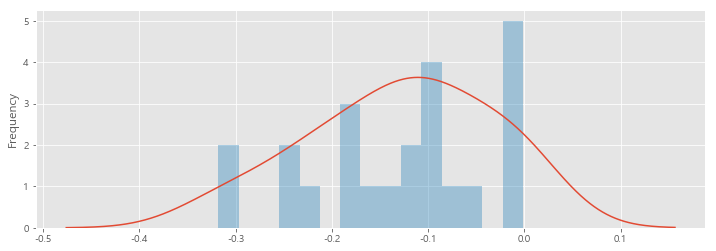

In [54]:
pd.Series(list({v for k,v in risk_dict.items()})).plot(kind='kde', figsize=(12,4))
pd.Series(list({v for k,v in risk_dict.items()})).plot(kind='hist', bins=15,alpha=.4, figsize=(12,4))

In [55]:
aux_dict

{'가구': (162.4, 90),
 '가전': (1146.4, 497),
 '광학제품': (1200.0666666666666, 703),
 '레저업소': (22536.666666666668, 17796),
 '레저용품': (10008.4, 6715),
 '문화취미': (7888.666666666667, 4168),
 '보건위생': (21976.466666666667, 16916),
 '사무통신': (66447.46666666666, 62858),
 '서적문구': (10217.4, 9535),
 '수리서비스': (2058.3333333333335, 459),
 '숙박': (4211.133333333333, 3033),
 '신변잡화': (4855.0, 3640),
 '연료판매': (27325.466666666667, 22682),
 '요식업소': (460009.06666666665, 427120),
 '유통업': (368488.6, 339132),
 '음료식품': (41970.13333333333, 35872),
 '의료기관': (80710.2, 9636),
 '의복': (11913.866666666667, 10583),
 '자동차 정비': (14175.533333333333, 11680),
 '자동차판매': (144.13333333333333, 25),
 '전기': (51.785714285714285, 5),
 '주방용구': (491.3333333333333, 166),
 '직물': (419.6666666666667, 222)}

### 회복탄력성 ( Resilience )  

In [58]:
register_2019= register.query('year==2019')
register_2020= register.query('year==2020')

In [59]:
tmp = register_2019.groupby(['MCT_CAT_NM','weekofyear'])['USE_CNT'].sum().\
        reset_index(name='USE_CNT_2019').\
        merge(
                register_2020.groupby(['MCT_CAT_NM','weekofyear'])['USE_CNT'].sum().\
                reset_index(name='USE_CNT_2020')
        ).eval('USE_CNT_RATE = (USE_CNT_2020/USE_CNT_2019)').\
        query('weekofyear >=9 & weekofyear <= 21')

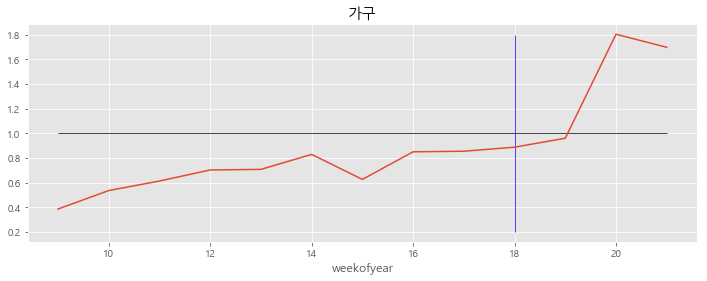

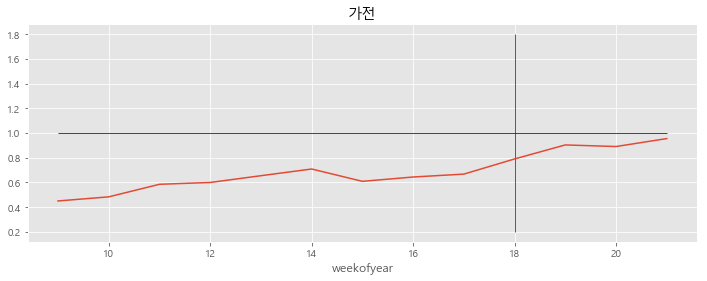

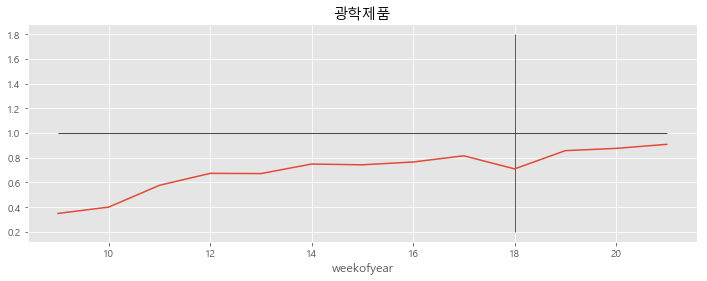

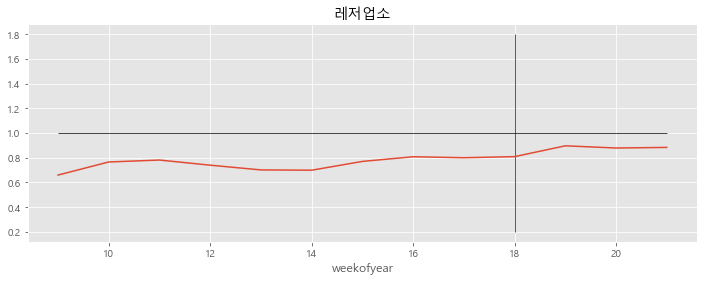

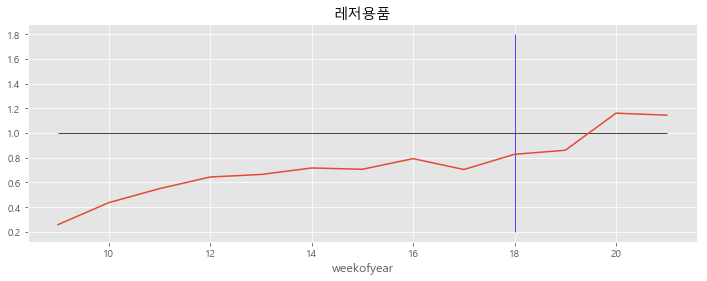

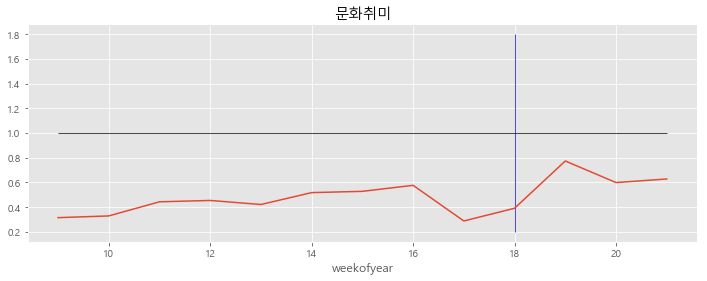

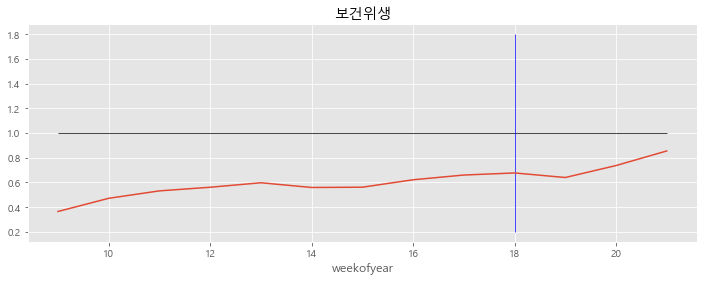

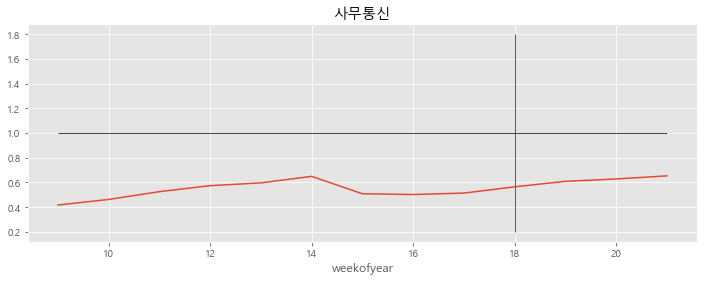

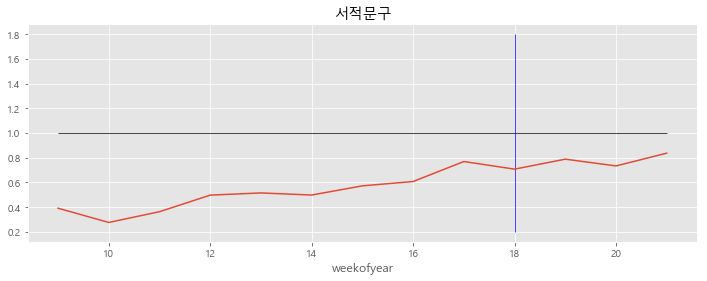

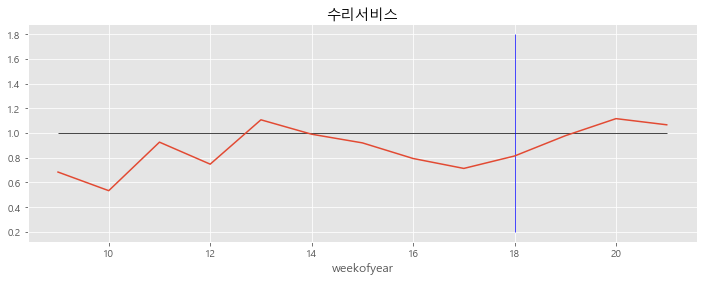

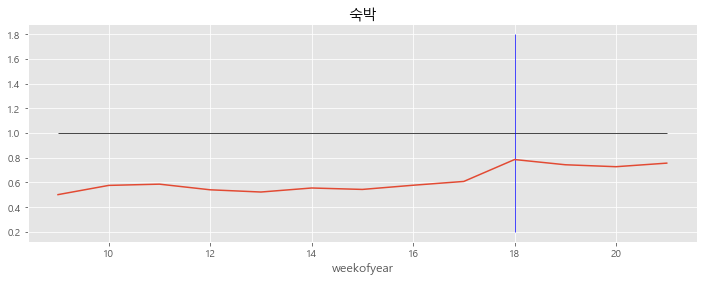

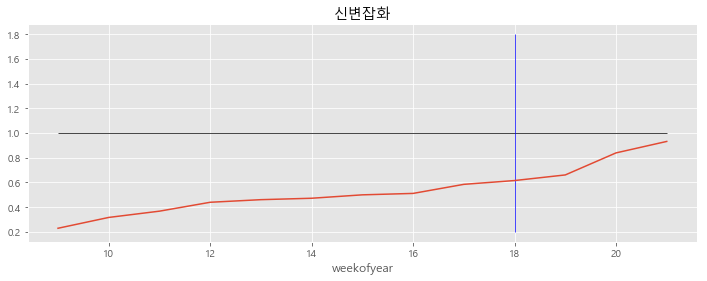

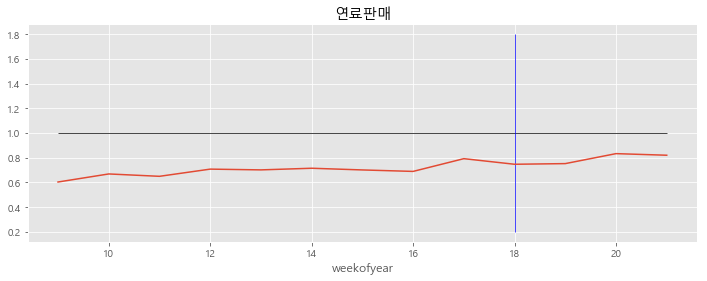

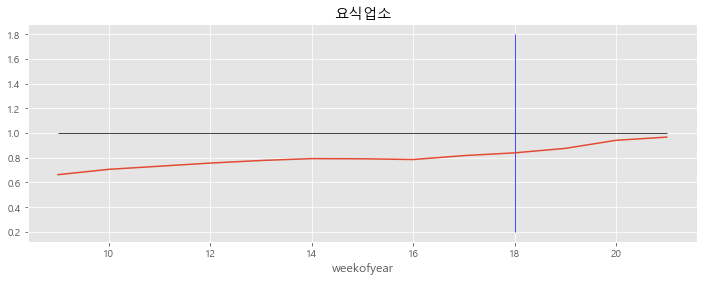

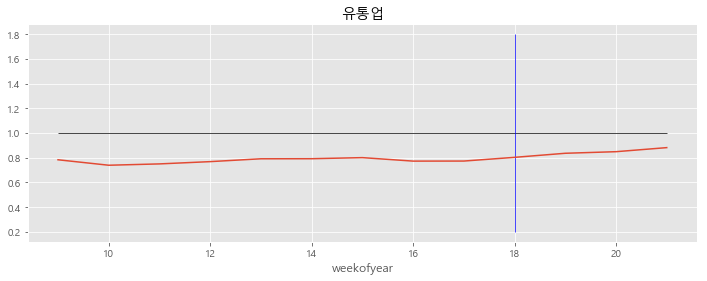

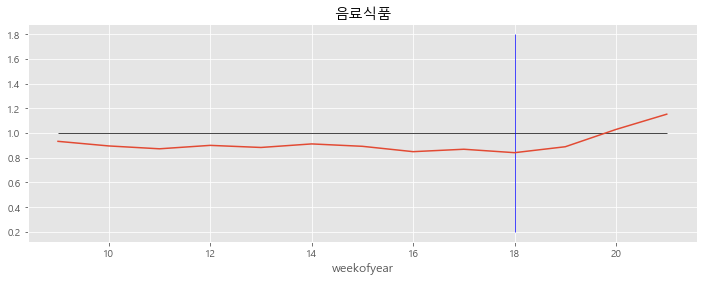

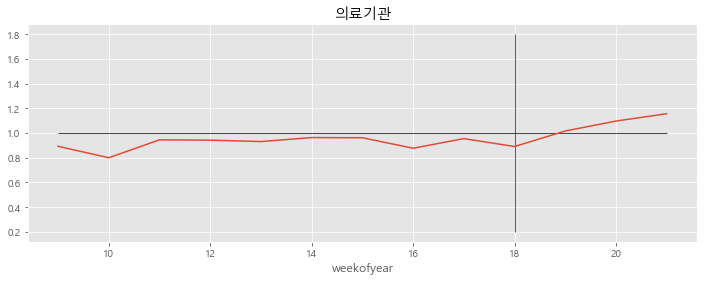

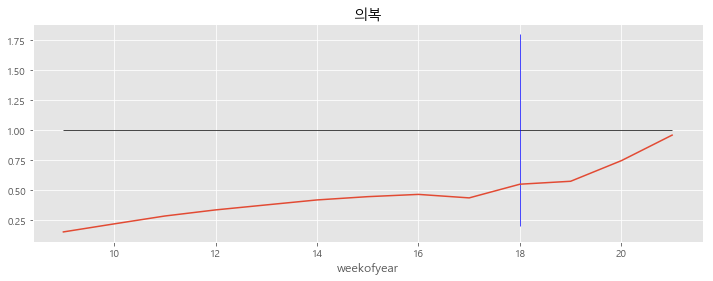

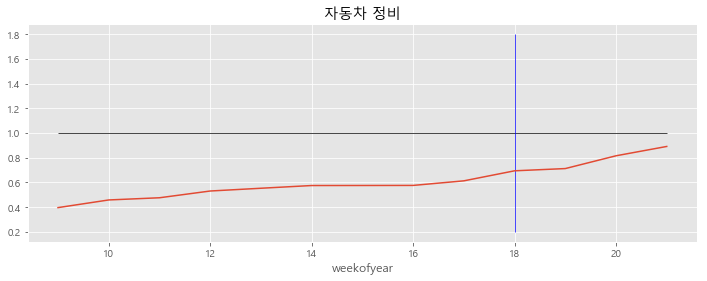

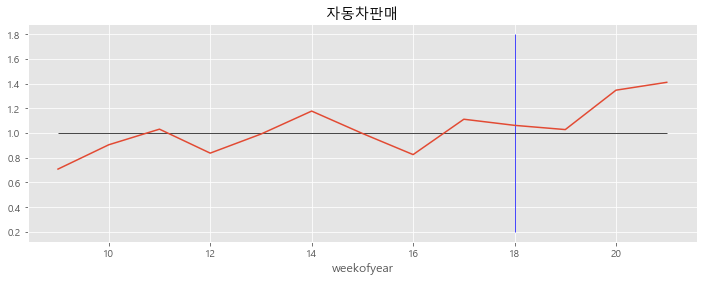

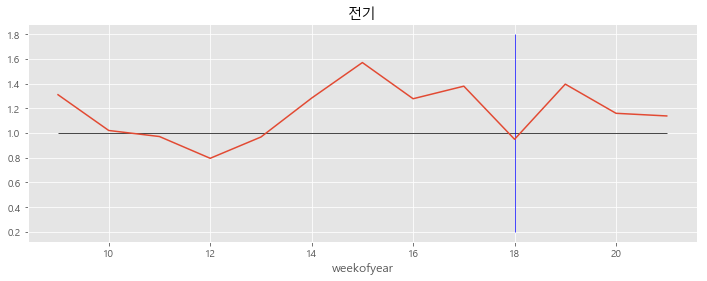

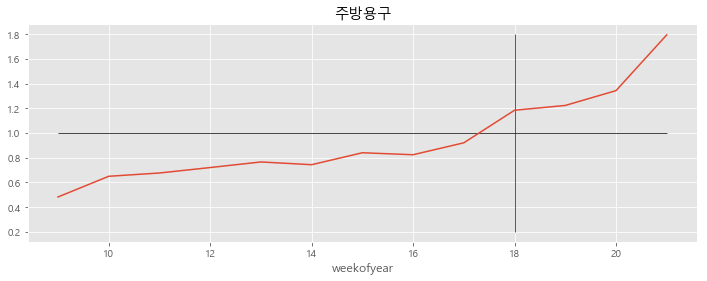

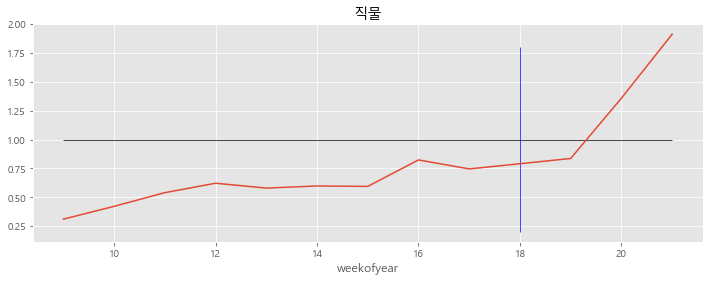

In [60]:
for cat in sorted(tmp.MCT_CAT_NM.unique()):
    tmp.loc[tmp.MCT_CAT_NM==cat].set_index('weekofyear').USE_CNT_RATE.plot(figsize=(12,4))
    plt.title(f'{cat}')
    plt.hlines(y=1, xmin= 9, xmax=21, color='k',linewidth=.7)
    plt.vlines(x=18, ymin=.2, ymax=1.8, color='b', linewidth=.7)
    plt.show()

$Resilence Index = {\sum_{i=1}^N r_i \cdot t_i \over N}$  
$ r_i :$ 전년 동주 대비 비율  
$ t_i :$ 동년 전주 대비 비율
  
  
$Modification Version$  
$Resilence Index = {\alpha \sum_{k=1}^N (N-k+1) \cdot r_k \over \sum_{k=1}^N k} $  
$ r_k :$ 전주 대비 비율  
$\alpha :$ 회복기간 마지막주(5월미포함시 18주, 포함시 21주) 기준 전년대비 비율

In [61]:
def WTW_ratio(df, contain_may=False, value='USE_CNT'):
    def compare_(sub_df,contain_may=contain_may):
        if contain_may:
            pre_use_cnt = sub_df[value].values
            use_cnt = sub_df.shift().fillna(method='bfill')[value].values
        else:
            pre_use_cnt = sub_df.iloc[:-3][value].values
            use_cnt = sub_df.iloc[:-3].shift().fillna(method='bfill')[value].values
        return np.array(np.divide(pre_use_cnt,use_cnt))
    
    
    tmp = df.query('year==2020 & weekofyear>=9 & weekofyear<=21').reset_index(drop=True)
    
    res = tmp.groupby(['MCT_CAT_NM','weekofyear'])[value].sum().\
            reset_index().\
            groupby('MCT_CAT_NM').\
            apply(compare_).\
            reset_index(name='ratio_wtw').\
            set_index('MCT_CAT_NM')
    
    return res    

In [62]:
def YOY_ratio(df, val='USE_CNT'):
    tmp_2019 = df.query('year==2019 & weekofyear>=9 & weekofyear<=21').reset_index(drop=True)
    tmp_2020 = df.query('year==2020 & weekofyear>=9 & weekofyear<=21').reset_index(drop=True)
    
    total_yoy_rate = tmp_2019.groupby(['MCT_CAT_NM','weekofyear'])[val].sum().\
                                reset_index(name='USE_CNT_2019').\
                                merge(
                                        tmp_2020.groupby(['MCT_CAT_NM','weekofyear'])[val].sum().\
                                        reset_index(name='USE_CNT_2020')
                                    ).eval('USE_CNT_RATE = (USE_CNT_2020/USE_CNT_2019)')
    
    cat_yoy_rate = total_yoy_rate.groupby(['MCT_CAT_NM'])['USE_CNT_RATE'].\
                                    apply(lambda x : np.array(x)).\
                                    reset_index(name='ratio_yoy').\
                                    set_index('MCT_CAT_NM')
    
    return cat_yoy_rate

In [63]:
def resilience_index(df, value='USE_CNT'):
    #기간 9주차이후 / 회복이 시작된 주차
    
    # 가중이동평균
    def weighted_moving_average(array):
        N = len(array)
        weight = np.array(range(1,N+1))
        return np.sum(array*weight)/np.sum(weight)
    
    # 가중이동편균_reversed weight
    # 코로나 확산이후 얼마나 빠르게 회복했는가를 중점으로 보기위해 코로나 확산시기에 가까울수록 가중치를 높게 설정함
    def weighted_moving_average_r(array):
        N = len(array)
        weight = np.array(range(N,0,-1))
        return np.sum(array*weight)/np.sum(weight)
    
    resilience_index = WTW_ratio(df, value=value)
    resilience_index['resilience_index'] = resilience_index['ratio_wtw'].apply(weighted_moving_average_r)
    last_week_index = len(resilience_index['ratio_wtw'][0])-1

    resilience_index = resilience_index.drop('ratio_wtw', axis=1)
    
    # 코로나 확산이후 얼마나 많이 회복했는가를 고려하기 위해 전년 동주대비 비율을 구하고 영향력을 조금 줄이기 위해 제곱근을 사용
    yoy_ratio = YOY_ratio(df)
    
    resilience_index['resilience_index'] = np.multiply(resilience_index['resilience_index'].values,
                                                        np.sqrt(yoy_ratio.ratio_yoy.apply(lambda x : x[last_week_index]).values))
    
    #return resilience_index
    return resilience_index.to_dict().get('resilience_index')

$Resilience Index.v2 = {\sum_{k=1}^N \sqrt{(N-k+1)} \cdot (r_k+1 - r_k) \over \sum_{k=1}^N k}$
$r_k$ : 전년 동주 대비 비율

In [64]:
def resilience_index_v2(df, value='USE_CNT', mode='r'):
    #기간 9주차이후 / 회복이 시작된 주차
    # mode = 'r','n
    def f(arr, contain_may=False):
        tmp = []
        for i,v in enumerate(arr[:-1]):
            tmp.append(arr[i+1]-arr[i])

        if contain_may:
            return tmp
        return tmp[:-3]
    
    # 가중이동평균
    def weighted_moving_average(array):
        N = len(array)
        weight = np.array(range(1,N+1))
        return np.sum(array*weight)/np.sum(weight)
    
    # 가중이동편균_reversed weight
    # 코로나 확산이후 얼마나 빠르게 회복했는가를 중점으로 보기위해 코로나 확산시기에 가까울수록 가중치를 높게 설정함
    def weighted_moving_average_r(array):
        N = len(array)
        weight = np.sqrt(np.array(range(N,0,-1)))
        return np.sum(array*weight)/np.sum(weight)
    
    resilience_index = YOY_ratio(df, val=value)
    resilience_index['resilience_index'] = resilience_index['ratio_yoy'].apply(f)
    if mode == 'n':
        resilience_index['resilience_index'] = resilience_index['resilience_index'].apply(weighted_moving_average)
    elif mode =='r':
        resilience_index['resilience_index'] = resilience_index['resilience_index'].apply(weighted_moving_average_r)
    last_week_index = len(resilience_index['ratio_yoy'][0])-1

    # 코로나 확산이후 얼마나 많이 회복했는가를 고려하기 위해 전년 동주대비 비율을 구하고 영향력을 조금 줄이기 위해 제곱근을 사용
    resilience_index['resilience_index'] = np.multiply(resilience_index['resilience_index'].values,
                                                        resilience_index.ratio_yoy.apply(lambda x : x[last_week_index]).values)
    
    resilience_index = resilience_index.drop('ratio_yoy', axis=1)
    
    #return resilience_index
    return resilience_index.to_dict().get('resilience_index')

In [65]:
def resilience_index_v2(df, value='USE_CNT'):
    #기간 9주차이후 / 회복이 시작된 주차
    
    def f(arr, contain_may=False):
        tmp = []
        for i,v in enumerate(arr[:-1]):
            tmp.append(arr[i+1]-arr[i])

        if contain_may:
            return tmp
        return tmp[:-3]
    
    # 가중이동평균
    def weighted_moving_average(array):
        N = len(array)
        weight = np.array(range(1,N+1))
        return np.sum(array*weight)/np.sum(weight)
    
    # 가중이동편균_reversed weight
    # 코로나 확산이후 얼마나 빠르게 회복했는가를 중점으로 보기위해 코로나 확산시기에 가까울수록 가중치를 높게 설정함
    def weighted_moving_average_r(array):
        N = len(array)
        weight = np.sqrt(np.array(range(N,0,-1)))
        return np.sum(array*weight)/np.sum(weight)
    
    resilience_index = YOY_ratio(df, val=value)
    resilience_index['resilience_index'] = resilience_index['ratio_yoy'].apply(f)
    
    resilience_index['resilience_index'] = resilience_index['resilience_index'].apply(weighted_moving_average)
    last_week_index = len(resilience_index['ratio_yoy'][0])-1

    # 코로나 확산이후 얼마나 많이 회복했는가를 고려하기 위해 전년 동주대비 비율을 구하고 영향력을 조금 줄이기 위해 제곱근을 사용
    resilience_index['resilience_index'] = np.multiply(resilience_index['resilience_index'].values,
                                                        resilience_index.ratio_yoy.apply(lambda x : x[last_week_index]).values)
    
    resilience_index = resilience_index.drop('ratio_yoy', axis=1)
    
    #return resilience_index
    return resilience_index.to_dict().get('resilience_index')

In [66]:
resilience_index_v2(register)

{'가구': 0.07114131735984304,
 '가전': 0.03629331363204754,
 '광학제품': 0.0129873857434055,
 '레저업소': 0.010884315194939981,
 '레저용품': 0.05026292706979909,
 '문화취미': -0.0049421091286506414,
 '보건위생': 0.022090398871557778,
 '사무통신': 0.004793843426308134,
 '서적문구': 0.03495846681074406,
 '수리서비스': -0.0021129096960836227,
 '숙박': 0.03460453636575536,
 '신변잡화': 0.03433746088311744,
 '연료판매': 0.009031830222453952,
 '요식업소': 0.015780414467034074,
 '유통업': 0.005040697266723919,
 '음료식품': -0.011203627185619925,
 '의료기관': -0.006421787199440247,
 '의복': 0.03867027606527056,
 '자동차 정비': 0.029604312612014117,
 '자동차판매': 0.030559308689381663,
 '전기': -0.05139099502512807,
 '주방용구': 0.16100060698085836,
 '직물': 0.07993063641668244}

In [67]:
card_risk=risk_index(register)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.45it/s]


In [68]:
card_resilience=resilience_index(register)
risk=pd.DataFrame(card_risk.items(), columns=['MCT_CAT_NM', 'risk_index'])
resilience=pd.DataFrame(card_resilience.items(), columns=['MCT_CAT_NM', 'resilience_index'])
risk_resilience=risk.merge(resilience)

In [69]:
card_resilience2 = resilience_index_v2(register)
risk=pd.DataFrame(card_risk.items(), columns=['MCT_CAT_NM', 'risk_index'])
resilience=pd.DataFrame(card_resilience2.items(), columns=['MCT_CAT_NM', 'resilience_index'])
risk_resilience=risk.merge(resilience)

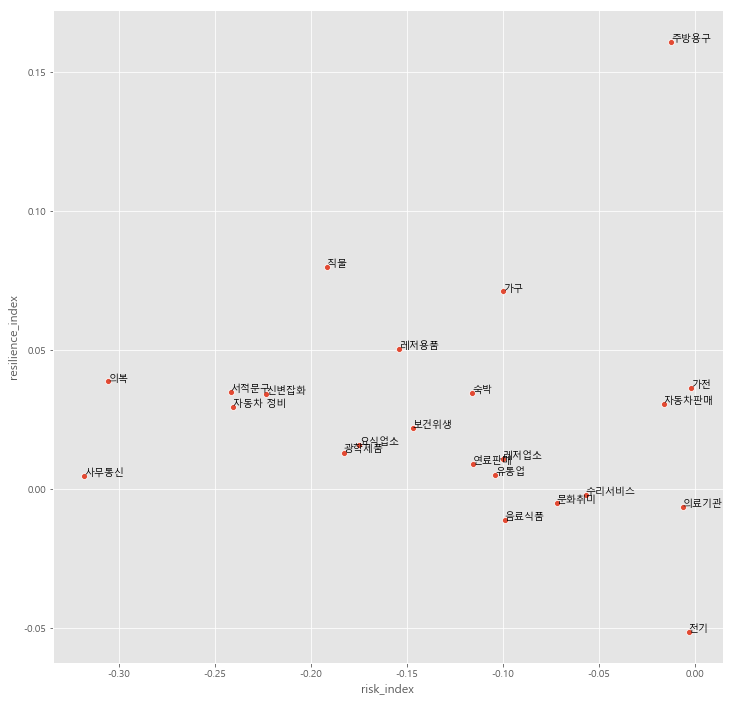

In [70]:
fig, ax = plt.subplots(figsize=(12,12))

x = risk_resilience.risk_index
y = risk_resilience.resilience_index

sns.scatterplot(x, y, ax=ax)

for i, label in enumerate(risk_resilience.MCT_CAT_NM):
    ax.annotate(f'{label}', (x[i],y[i]))

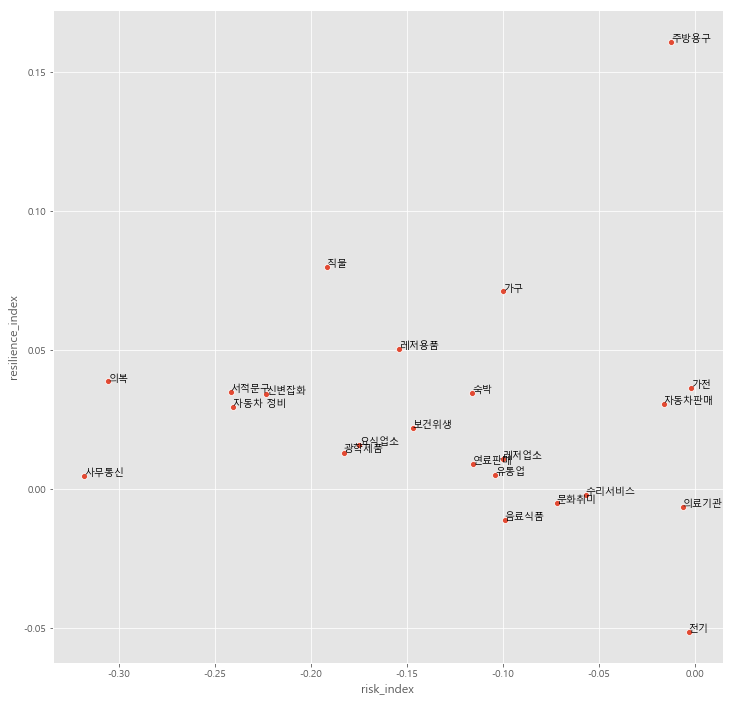

In [71]:
fig, ax = plt.subplots(figsize=(12,12))

x = risk_resilience.risk_index
y = risk_resilience.resilience_index

sns.scatterplot(x, y, ax=ax)

for i, label in enumerate(risk_resilience.MCT_CAT_NM):
    ax.annotate(f'{label}', (x[i],y[i]))

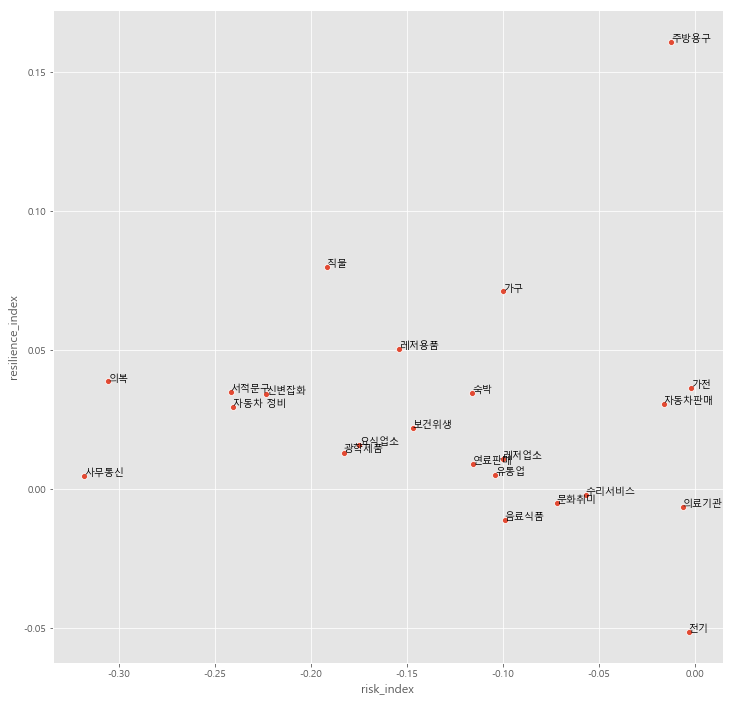

In [72]:
fig, ax = plt.subplots(figsize=(12,12))

x = risk_resilience.risk_index
y = risk_resilience.resilience_index

sns.scatterplot(x, y, ax=ax)

for i, label in enumerate(risk_resilience.MCT_CAT_NM):
    ax.annotate(f'{label}', (x[i],y[i]))

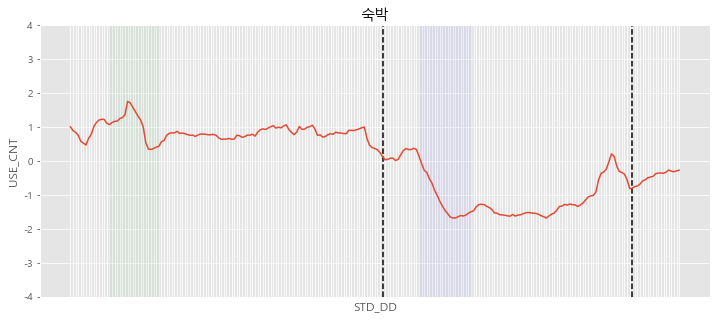

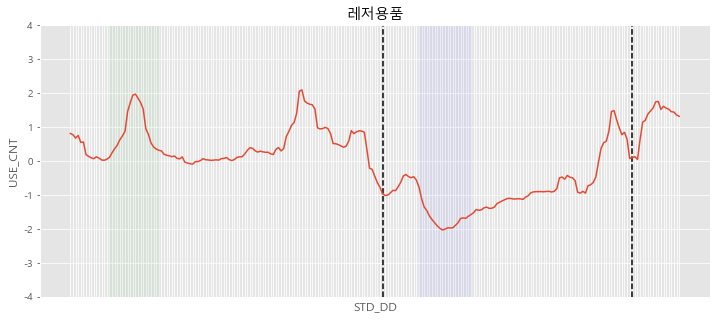

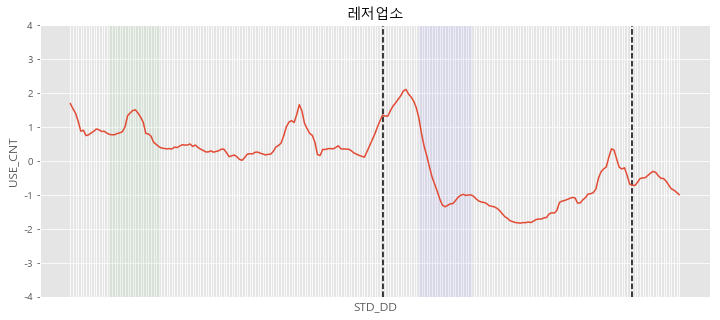

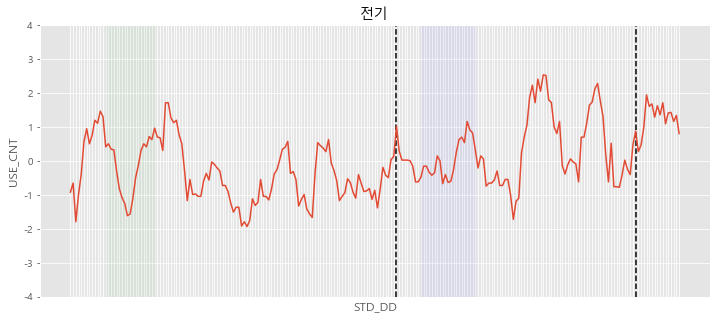

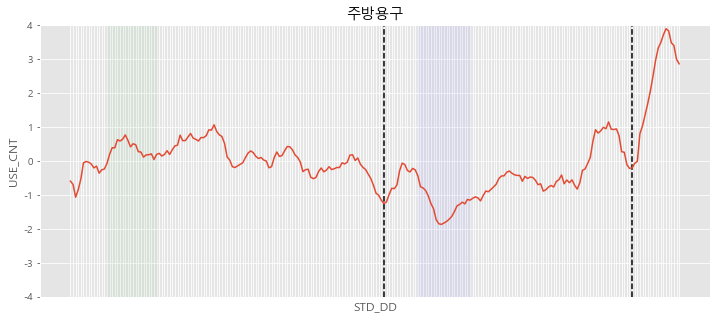

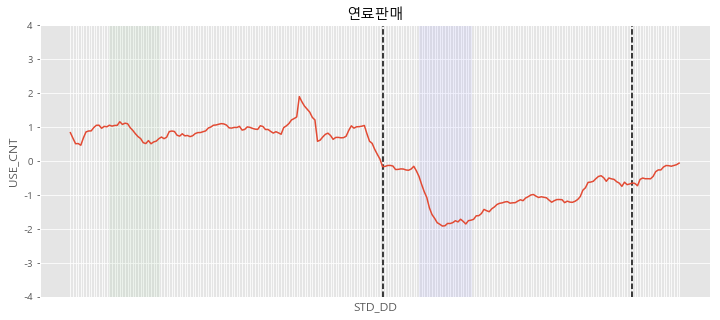

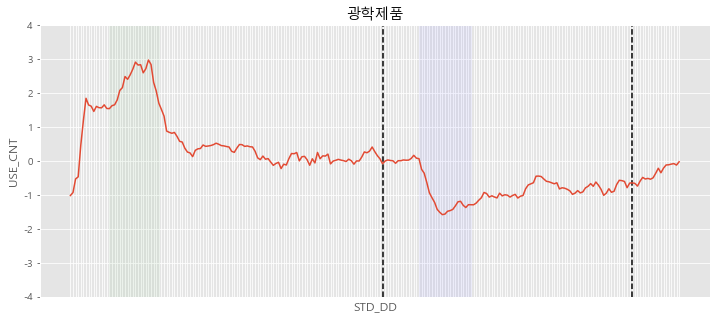

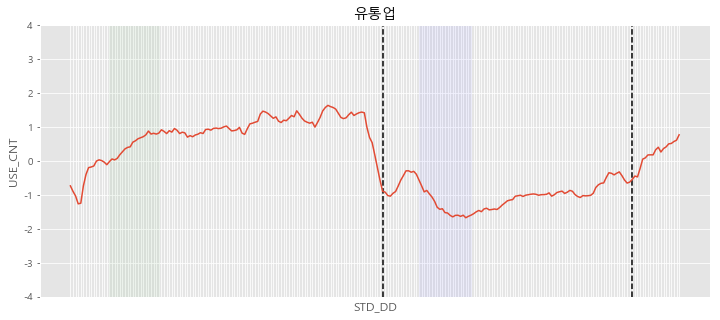

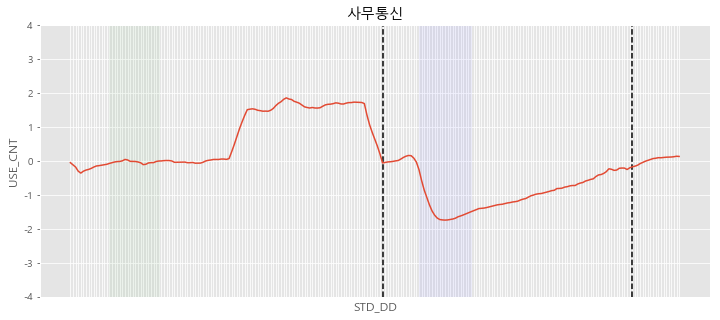

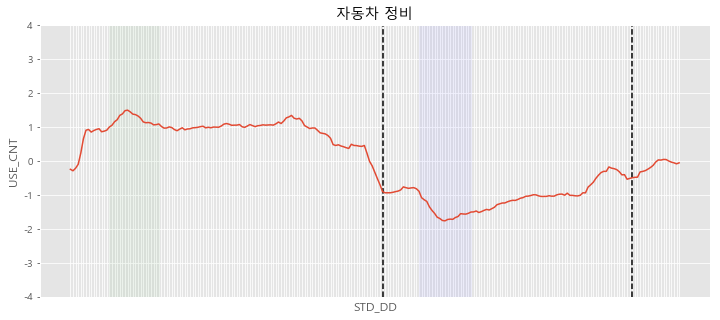

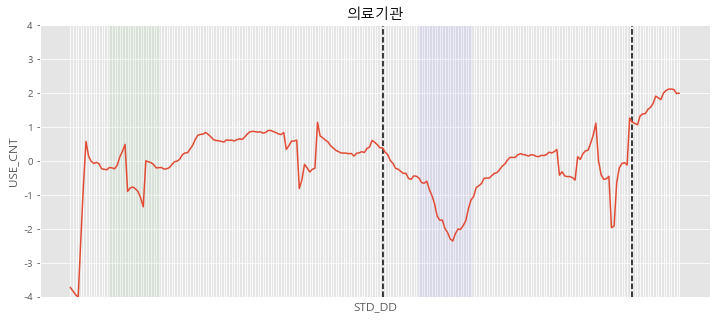

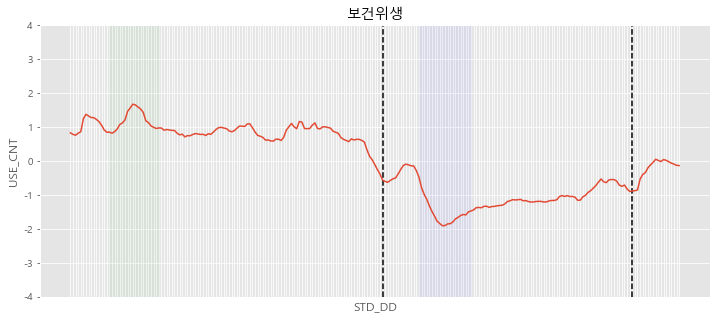

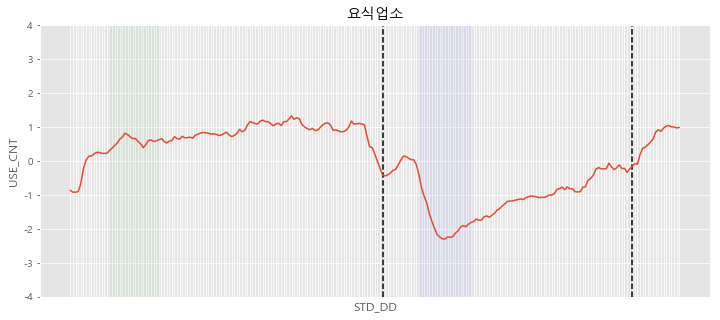

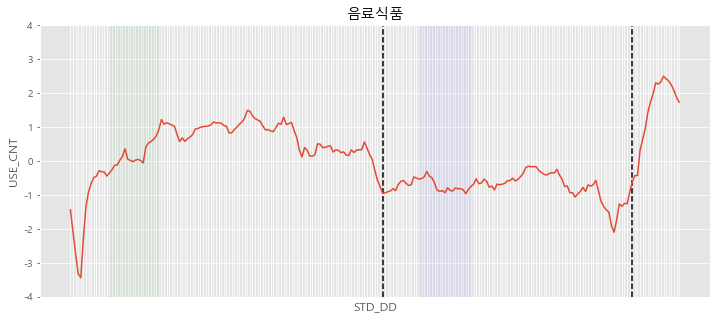

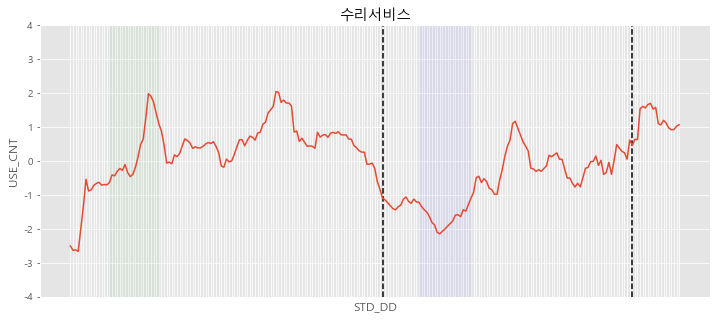

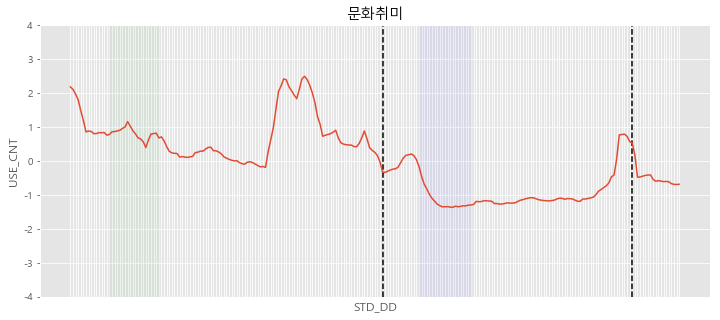

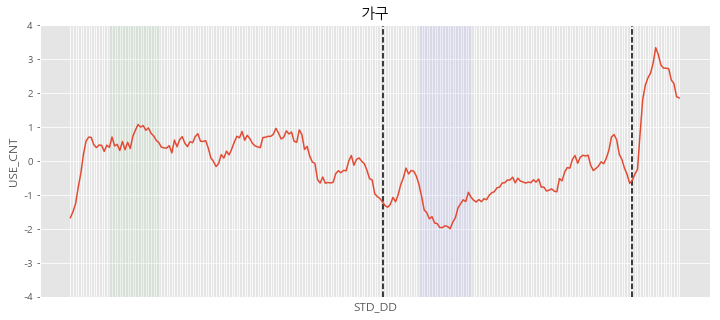

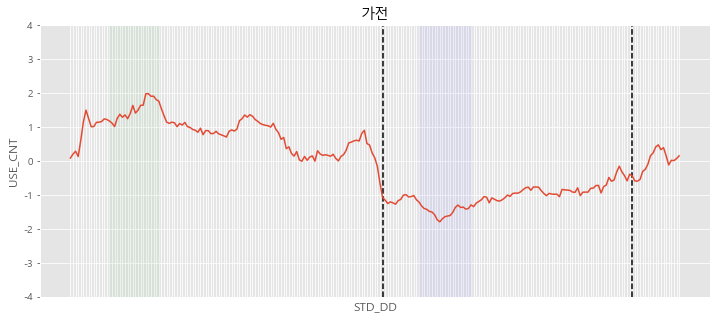

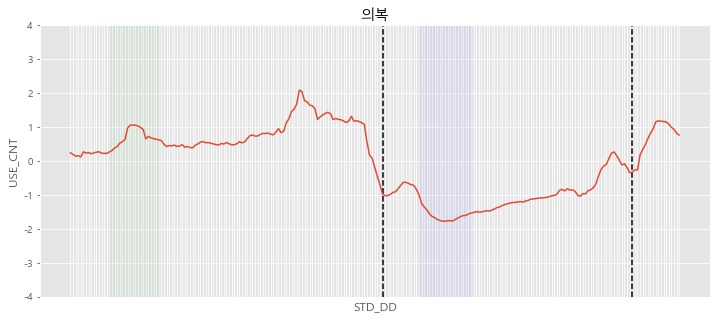

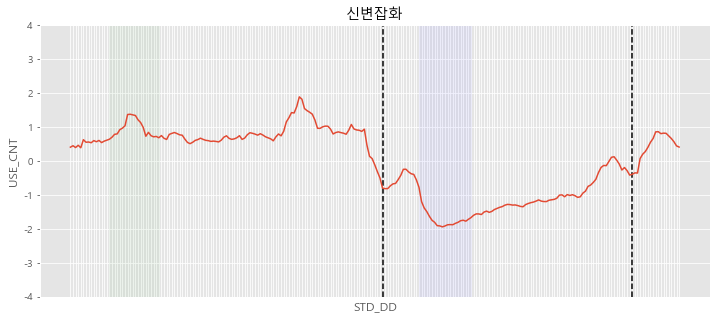

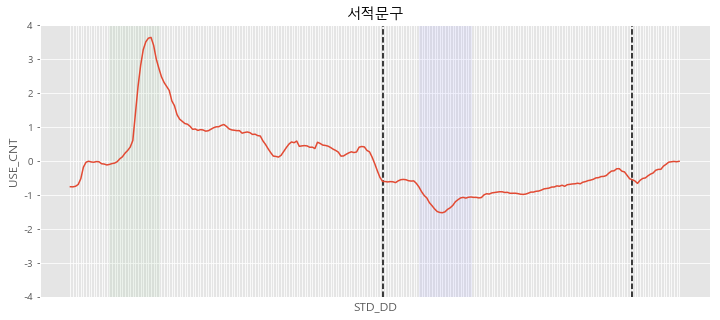

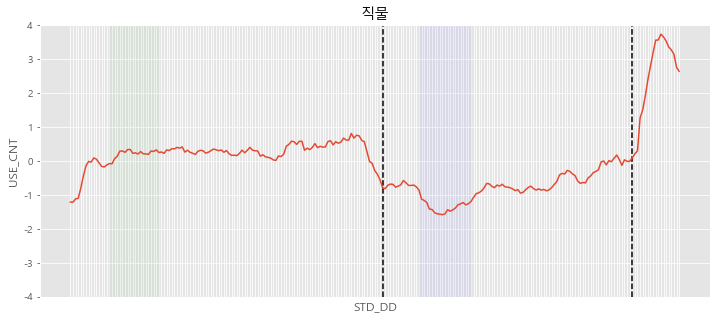

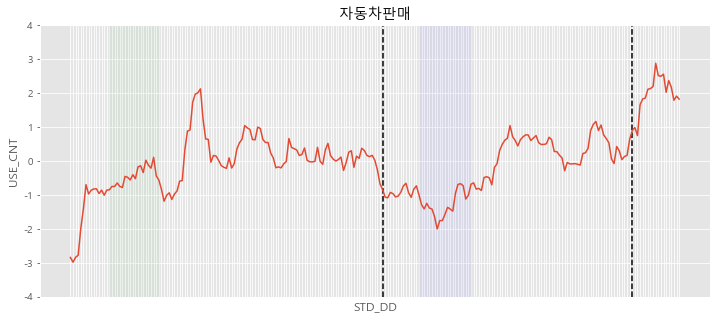

In [73]:
for cat in register.MCT_CAT_NM.unique():
    data  = register.loc[register.MCT_CAT_NM == cat].groupby(['STD_DD']).USE_CNT.sum().rolling(window=7).mean().dropna().reset_index()
    scaler = StandardScaler()
    data['USE_CNT'] = scaler.fit_transform(data[['USE_CNT']])
    data['STD_DD'] = data['STD_DD'].astype(str)
    
    plt.figure(figsize=(12,5))
    sns.lineplot(
        data = data,
        x = 'STD_DD',
        y ='USE_CNT'
    )
    
    plt.title(f'{cat}')
    
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False
    )
    
    plt.vlines(x=data.STD_DD[120], ymin=-4, ymax=4, linestyles='--', color='k')
    plt.vlines(x='2020-05-13', ymin=-4, ymax=4, linestyles='--', color='k')
    plt.axvspan(xmin='2019-02-22', xmax='2019-03-13', color='g', alpha=0.05)
    plt.axvspan(xmin='2020-02-21', xmax='2020-03-12', color='b', alpha=0.05)
    
    plt.ylim(-4,4)
    plt.show()